In [17]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
from Cooking import checkAndCreateDir
from helpers import predictImage

from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D, Conv2DTranspose, Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
from keras_tqdm import TQDMNotebookCallback

In [12]:
# Load training images
train_images = pickle.load(open("images/scene/out_reshaped_scenes.p", "rb" ))

# Load image labels
labels = pickle.load(open("images/labelled/out_1d_labels.p", "rb" ))

# Make into arrays as the neural network wants these
train_images = np.array(train_images)
labels = np.array(labels)

In [13]:
# Normalize labels
labels = labels / 255

# Shuffle images along with their labels and split into training/validation sets
train_images, labels = shuffle(train_images, labels)
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)

# Set optimization parameters
batch_size = 128
epochs = 1000
pool_size = (2, 2)
input_shape = X_train.shape[1:]

In [57]:
# Neural Network
model = Sequential()
# Normalizes incoming inputs. First layer needs the input shape to work
model.add(BatchNormalization(input_shape=input_shape))

# Below layers were re-named for easier reading of model summary; this not necessary
# Conv Layer 1
model.add(Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1'))

# Conv Layer 2
model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'))

# Pooling 1
model.add(MaxPooling2D(pool_size=pool_size))

# Conv Layer 3
model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv3'))
model.add(Dropout(0.2))

# Pooling 2
model.add(MaxPooling2D(pool_size=pool_size))

# Upsample 1
model.add(UpSampling2D(size=pool_size))

# Deconv 1
model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv1'))
model.add(Dropout(0.2))

# Upsample 2
model.add(UpSampling2D(size=pool_size))

# Deconv 2
model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv2'))

# Final layer - only including one channel so 1 filter
model.add(Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Final'))

In [66]:
# Using a generator to help the model use less data
# Channel shifts help with shadows slightly
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

MODEL_OUTPUT_DIR = 'model/lanes'

plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', '{epoch:02d}', '{val_loss:.7f}'))
checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback]

In [67]:
# Compiling and training the model
model.compile(optimizer='Adam', loss='mean_squared_error')
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(X_train)/batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(X_val, y_val), 
                    callbacks=callbacks)

# Freeze layers since training is done
model.trainable = False
model.compile(optimizer='Adam', loss='mean_squared_error')


# Save model architecture and weights
model.save('model/lanes/trained_lane_model_3_layer.h5')

# Show summary of model
model.summary()

ValueError: Error when checking target: expected dropout_32 to have 2 dimensions, but got array with shape (79, 80, 160, 1)

In [4]:
from keras.models import load_model

model = load_model('model/lanes/trained_lane_model_3_layer_new_2.h5')


Instructions for updating:
keep_dims is deprecated, use keepdims instead


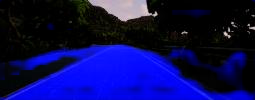

In [5]:
res = predictImage(model, "images/test/out_scene_965.jpg")
    
res

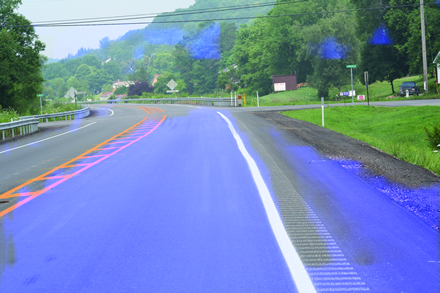

In [9]:
#res = predictImage(model, "images/two-lane-road.jpg", shape=(452, 602, 3))
#res = predictImage(model, "images/two-lane-road-2.jpg", shape=(229, 400, 3))
res = predictImage(model, "images/two-lane-road-3.jpg", shape=(293, 440, 3))
    
res

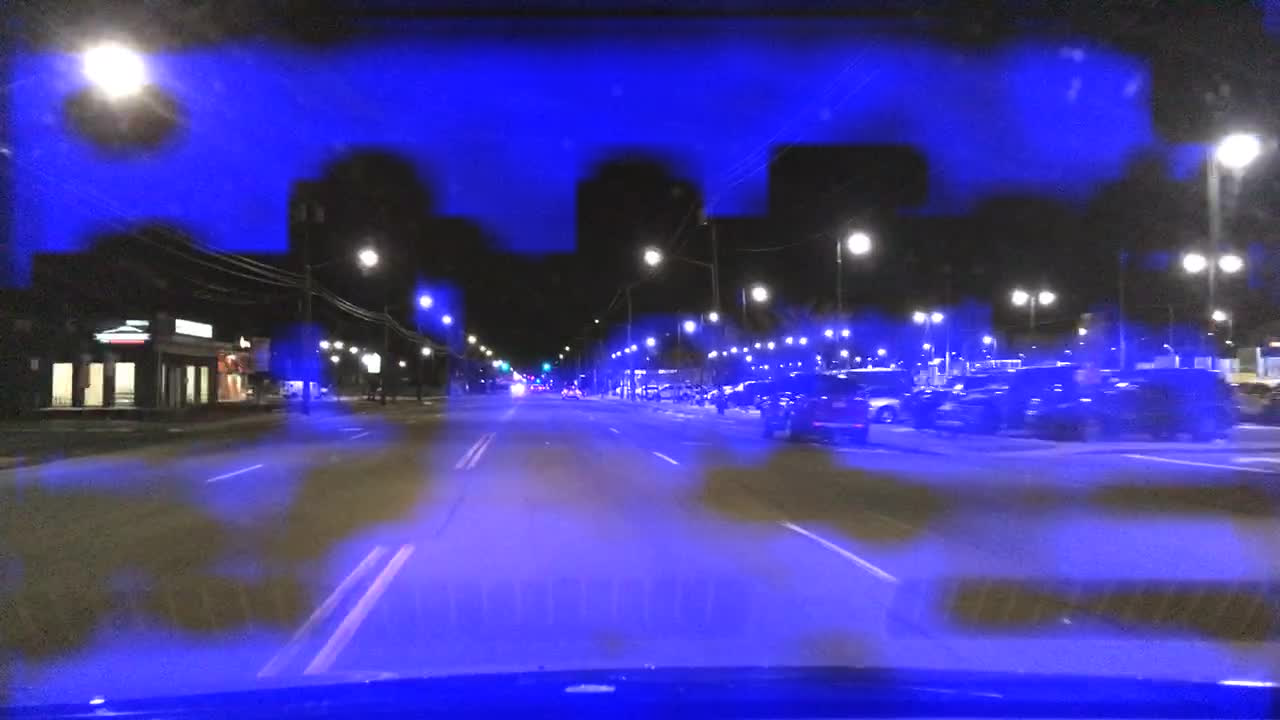

In [10]:
# test on a BDD image
res = predictImage(model, "images/f1a175b4-ea107c2b.jpg", shape=(720, 1280))

res